# Fraud Detection Case Study - Accredian Assignment 
## Candidate: Velagala Rohan Sai Kumar Reddy
## Date: 25-08-2025

In [3]:
# 1. Problem Statement
"""
Business Context:
We need to build a fraud detection model for a financial dataset (~6.3M rows).The goal is to detect fraudulent transactions and provide business insights 
for prevention and evaluation of anti-fraud measures.
Target Variable: isFraud
"""

'\nBusiness Context:\nWe need to build a fraud detection model for a financial dataset (~6.3M rows).The goal is to detect fraudulent transactions and provide business insights \nfor prevention and evaluation of anti-fraud measures.\nTarget Variable: isFraud\n'

In [6]:
# 2. Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

In [8]:
# 3. Load Dataset
df = pd.read_csv("fraud.csv")

In [9]:
print("Shape of dataset:", df.shape)

Shape of dataset: (6362620, 11)


In [10]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Data Cleaning & Feature Engineering

In [11]:
# Drop ID columns (not predictive)
df = df.drop(['nameOrig', 'nameDest'], axis=1)

In [15]:
# Feature engineering: balance differences
df['balanceDiffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']
df['balanceDiffDest'] = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']

In [16]:
# One-hot encode transaction type
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [17]:
# Check missing values
print(df.isnull().sum())

step               0
amount             0
oldbalanceOrg      0
newbalanceOrig     0
oldbalanceDest     0
newbalanceDest     0
isFraud            0
isFlaggedFraud     0
balanceDiffOrig    0
balanceDiffDest    0
type_CASH_OUT      0
type_DEBIT         0
type_PAYMENT       0
type_TRANSFER      0
dtype: int64


In [19]:
# Drop rows with missing values (if any)
df = df.dropna()

### Exploratory Data Analysis (EDA)

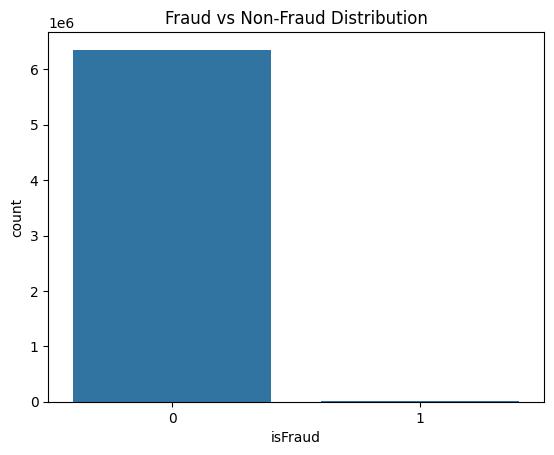

In [25]:
# Fraud vs Non-Fraud distribution
sns.countplot(x='isFraud', data=df)
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()

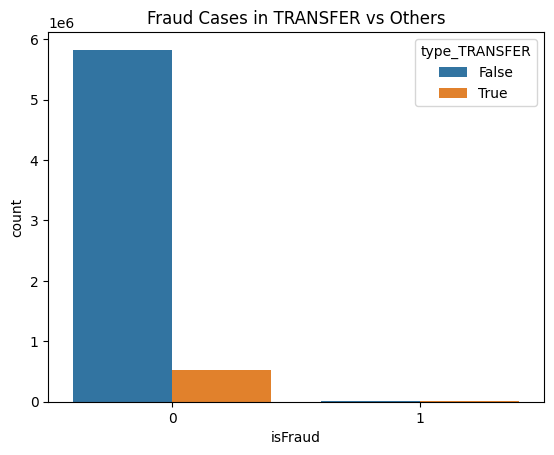

In [22]:
# Distribution of transaction types
sns.countplot(x='isFraud', hue='type_TRANSFER', data=df)
plt.title("Fraud Cases in TRANSFER vs Others")
plt.show()


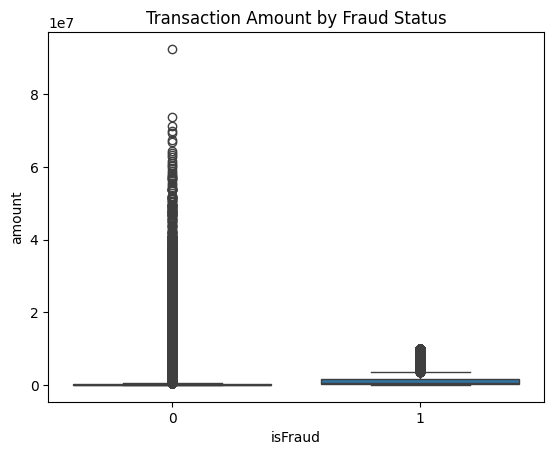

In [23]:
# Transaction amount distribution
sns.boxplot(x='isFraud', y='amount', data=df)
plt.title("Transaction Amount by Fraud Status")
plt.show()

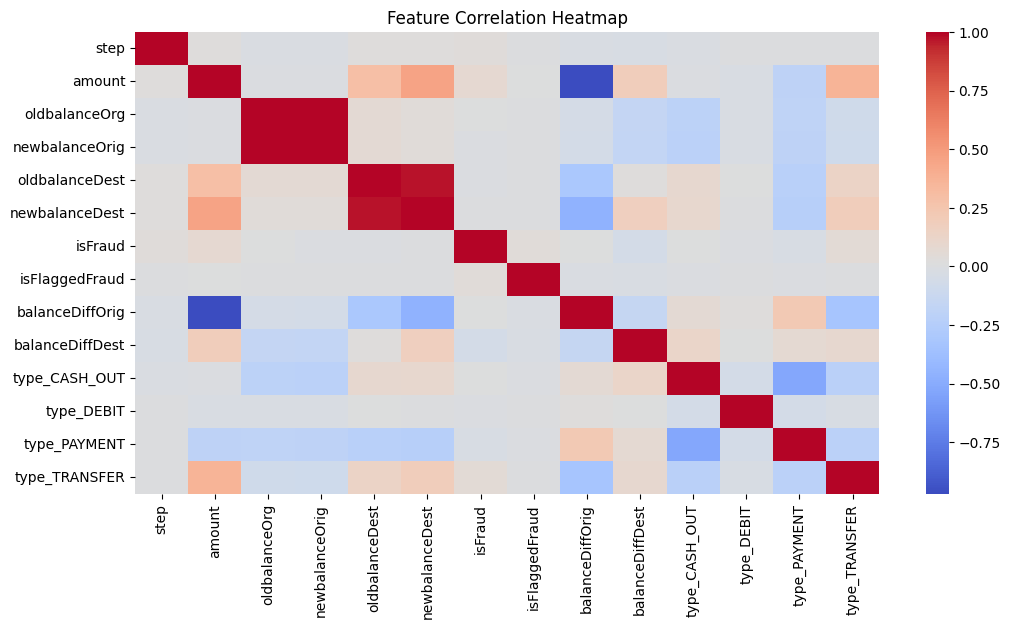

In [24]:
# Correlation heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

### Split & Balance Dataset

In [29]:
# Define features and target
X = df.drop('isFraud', axis=1)
y = df['isFraud']
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print("Before SMOTE:\n", y.value_counts())
print("After SMOTE:\n", y_res.value_counts())

Before SMOTE:
 isFraud
0    6354407
1       8213
Name: count, dtype: int64
After SMOTE:
 isFraud
0    6354407
1    6354407
Name: count, dtype: int64


In [28]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.3, random_state=42, stratify=y_res
)
# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Model Training

In [ ]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

### Model Evaluation

In [ ]:
# Reports
print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))
print("Random Forest:\n", classification_report(y_test, y_pred_rf))
print("XGBoost:\n", classification_report(y_test, y_pred_xgb))

In [ ]:
# Confusion Matrix for RF
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label="Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [ ]:
print("ROC-AUC (Random Forest):", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

### Feature Importance

In [ ]:
# Feature importance (Random Forest)
importances = rf.feature_importances_
feat_names = X.columns
imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
imp_df = imp_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=imp_df)
plt.title("Feature Importance - Random Forest")
plt.show()

### Insights & Recommendations

## Key Insights
#### Fraud is concentrated in TRANSFER and CASH-OUT transactions.
- Many fraudulent cases show oldbalanceOrg > 0 and newbalanceOrg = 0.
- isFlaggedFraud rarely triggers - limited usefulness.
- Transaction amount and balance inconsistencies are strong fraud predictors.

## Recommendations
#### 1. Implement real-time anomaly detection for TRANSFER and CASH-OUT.
#### 2. Require multi-factor authentication for transactions > 200,000.
#### 3. Introduce balance consistency checks to flag impossible transactions.
#### 4. Deploy geolocation/IP monitoring for suspicious access.

## Evaluating Effectiveness
#### Track fraud % before vs after preventive measures.
#### Measure Precision & Recall of fraud detection system.
#### Monitor false positives to avoid impacting genuine customers.
